<span style="color: white; background-color: green; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">♻️RESNET50 VS VGG16♻️</span>


![](http://www.clearitwaste.co.uk/wp-content/uploads/2022/01/xCIW_Waste.png.pagespeed.ic.D8betJh5Mf.png)

# Project Video Link-->> https://youtu.be/q4FNsbfMtBM

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 56px; font-weight: bold;">♻️Waste classification♻️</span>


# 1- Import Libraries

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import skimage.io
import tensorflow 

import os
import random
from PIL import Image

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# 2 - Viewing Sample Images

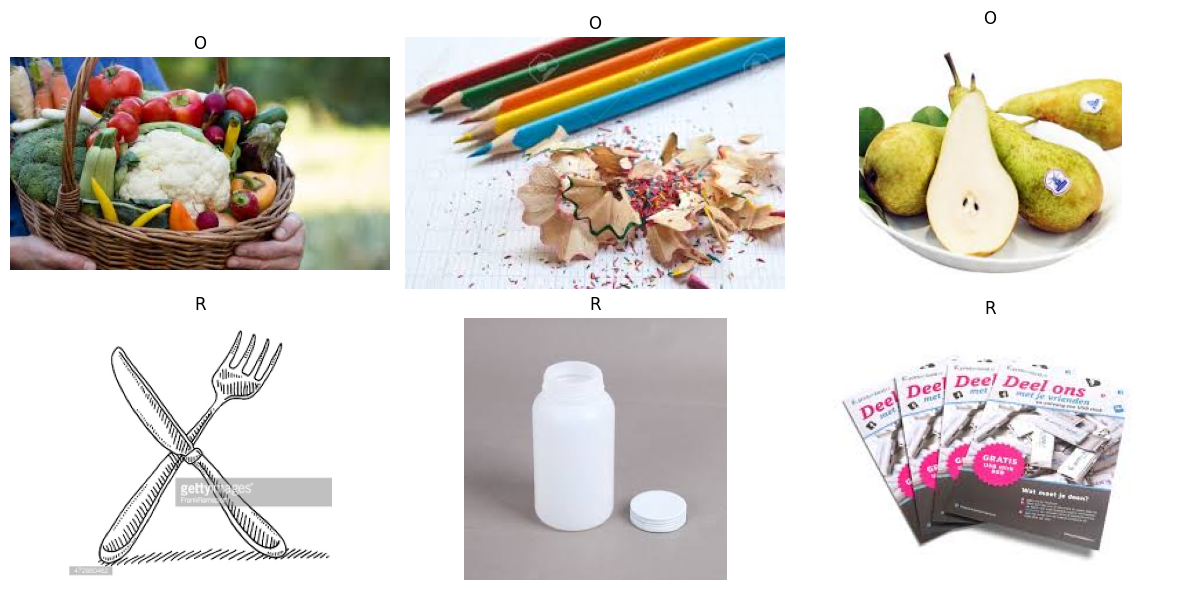

In [30]:
# Path setup
base_path = '/kaggle/input/waste-classification-data/DATASET/TRAIN'
categories = ['O', 'R']


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for row, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    image_files = os.listdir(category_path)
    selected_images = random.sample(image_files, 3)

    for col, img_file in enumerate(selected_images):
        img_path = os.path.join(category_path, img_file)
        img = Image.open(img_path)

        ax = axes[row][col]
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')

plt.tight_layout()
plt.show()

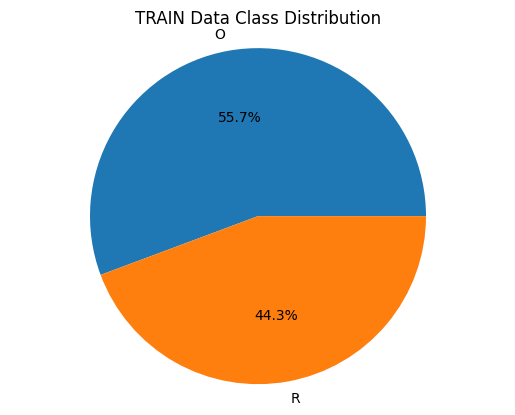

In [ ]:
train_dir = '/kaggle/input/waste-classification-data/DATASET/TRAIN'

labels = ['O', 'R']
counts = [len(os.listdir(os.path.join(train_dir, label))) for label in labels]

plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("TRAIN Data Class Distribution")
plt.axis('equal')
plt.show()


# 3 - Data Augumentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/waste-classification-data/DATASET/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')



valid_dataset = valid_datagen.flow_from_directory(directory = '/kaggle/input/waste-classification-data/DATASET/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


# 4- Model Building - VGG16

In [7]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

I0000 00:00:1745769177.468388      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745769177.469079      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Summary

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [11]:
# Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,927,873 (106.54 MB)

 Trainable params: 13,160,961 (50.21 MB)

 Non-trainable params: 14,766,912 (56.33 MB)

In [12]:
# Model Compile 

adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=adam)

In [13]:
# Defining Callbacks

filepath = './best_model.keras'

earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              patience=2,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             mode='max', 
                             save_best_only=True, 
                             verbose=1)

callback_list = [earlystopping, checkpoint]

In [14]:
# Model Fitting 

model_history = model.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=5,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/5


I0000 00:00:1745769208.576140     110 service.cc:148] XLA service 0x7b4da8006320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745769208.576739     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745769208.576758     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745769209.122335     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-27 15:53:37.261418: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earlies

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8223 - loss: 0.4093
Epoch 1: val_accuracy improved from -inf to 0.88387, saving model to ./best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.8225 - loss: 0.4088 - val_accuracy: 0.8839 - val_loss: 0.2758
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8946 - loss: 0.2651
Epoch 2: val_accuracy did not improve from 0.88387
142/142 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.8946 - loss: 0.2650 - val_accuracy: 0.8774 - val_loss: 0.3034
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8987 - loss: 0.2467
Epoch 3: val_accuracy improved from 0.88387 to 0.89029, saving model to ./best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8987 - loss: 0.2467 - val_accuracy: 0.8903 - val_loss: 0.2742
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9087 - loss: 0.2295
Epoch 4: val_accuracy did not improve from 0.89029
142/142 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/st

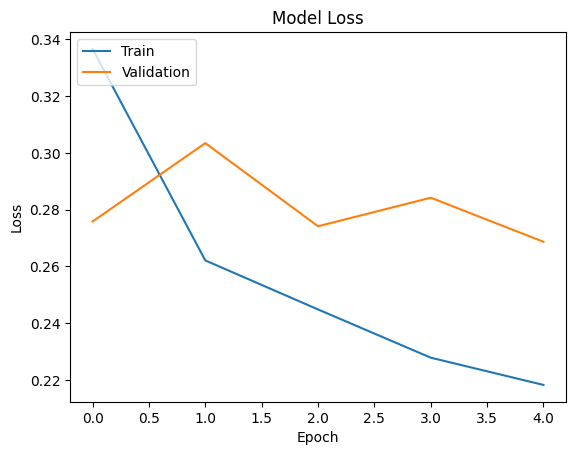

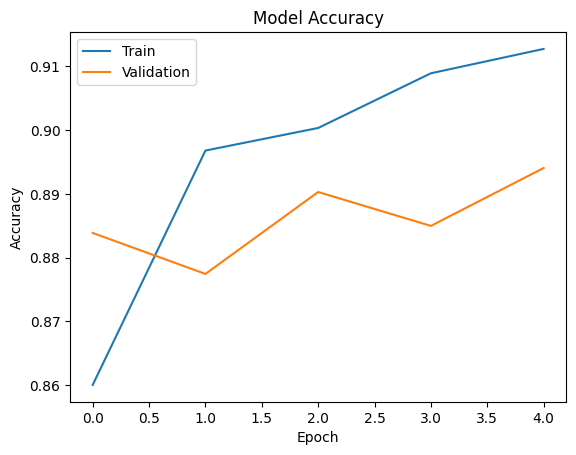

In [15]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Summarize model accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Test Data 

test_data = test_datagen.flow_from_directory(directory = '/kaggle/input/waste-classification-data/DATASET/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [17]:

model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8914 - loss: 0.3399


[0.3360508680343628, 0.8925586938858032]

# 5- Model Building -RESNET50

In [20]:
resnet = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [21]:
# Freezing Layers 

for layer in resnet.layers:
    layer.trainable=False

In [22]:
# Defining Layers

model2=Sequential()
model2.add(resnet)
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(512,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))

In [23]:
# Summary

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100352)              │         401,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,637,121 (288.53 MB)

 Trainable params: 51,846,657 (197.78 MB)

 Non-trainable params: 23,790,464 (90.75 MB)

In [24]:
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=adam)

In [25]:
# Defining Callbacks

earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              patience=2,
                              verbose=1)


callback_list = [earlystopping]

In [26]:
# Model Fitting 

history = model2.fit(train_dataset,
                          validation_data=valid_dataset,
                          epochs=5,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.6869 - loss: 0.6313 - val_accuracy: 0.6855 - val_loss: 0.5976
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.7626 - loss: 0.5014 - val_accuracy: 0.7624 - val_loss: 0.4958
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.7699 - loss: 0.4883 - val_accuracy: 0.7695 - val_loss: 0.4851
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.7778 - loss: 0.4751 - val_accuracy: 0.7824 - val_loss: 0.4822
Epoch 5/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.7898 - loss: 0.4636 - val_accuracy: 0.7766 - val_loss: 0.4739


In [27]:
model2.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 927ms/step - accuracy: 0.7614 - loss: 0.5358


[0.5346738696098328, 0.7664146423339844]

# 6- Image Prediction Demo

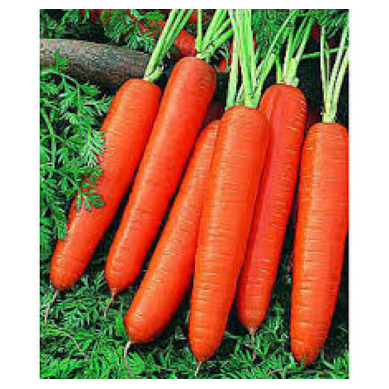

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The image belongs to **Organic waste** category


In [32]:
# Load and preprocess the image
img = load_img('/kaggle/input/waste-classification-data/DATASET/TEST/O/O_12572.jpg', target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
plt.imshow(img_array)
plt.axis('off')
plt.show()


# Expand dimensions to match model input shape: (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("The image belongs to **Recycle waste** category")
else:
    print("The image belongs to **Organic waste** category")

# 7- Saving the Model

In [29]:
model.save('model.h5')

<span style="color: black; background-color: yellow; padding: 10px 20px; border-radius: 10px; font-size: 56px; font-weight: bold;">       ♻️Keep Learning and Keep Upvoting♻️     </span>
